# BÁO CÁO BÀI TẬP LỚN
 **Học phần**: Machine Learning - INT3405_20
 
 **Giảng viên**: Trần Quốc Long
 
 **Sinh viên**: Lê Hữu Chung
 
 **MSSV**: 18020236
 

## **Introduction**
* Quora là một nền tảng cho phép mọi người học hỏi lẫn nhau. Trên Quora, mọi người đều có thể đặt câu hỏi và kết nối với những người khác, mong muốn được giao lưu với những người đóng góp thông tin chi tiết độc đáo và có câu trả lời chất lượng.
* Hiện nay, xử lý những nội dung độc hại và gây chia rẽ là một thách thức đối với bất kỳ trang web nào.
* Quora muốn giải quyết vấn đề này để giữ cho nền tảng của họ trở thành nơi mà người dùng có thể cảm thấy an toàn khi chia sẻ kiến thức với toàn cộng đồng.
* Vậy mục tiêu, thách thức của dự án này là nhận diện được những câu hỏi "insincere" - những câu hỏi không mang tính chất đóng góp, thiếu chân thành, thậm chí để đả kích một cá nhân, tập thể hay tổ chức nào đó. Ngoài ra, những câu hỏi có ý định đưa ra một tuyên bố hơn là tìm kiếm những câu trả lời hữu ích cũng cần bị loại bỏ.


## **List of contents**
1. Khởi tạo dự án
2. Tiền xử lý dữ liệu
3. Chuẩn bị mô hình
4. Huấn luyện mô hình

# **1. Khởi tạo dự án**

## 1.a Import các thư viện cần thiết.

In [ ]:
import time
import random
import pandas as pd
import numpy as np
import gc
import re
import torch
from torchtext import data
import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter
from textblob import TextBlob
from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torchtext.data import Example
from sklearn.metrics import f1_score
import torchtext
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer
from unidecode import unidecode

## 1.b Thiết lập các tham số cơ bản.

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 185777 # 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits

SEED = 2021

## 1.c Đảm bảo tính xác định (determinism) 

Vì ở phần sau, em dùng mô hình LSTM - train trên GPU nên sẽ thiếu tính "determinism" sau mỗi lần train. Có thể hiểu nôm na rằng sau 2 lần train với cùng một bộ dữ liệu, chúng ta sẽ có 2 mô hình không hoàn toàn giống nhau, một cái tốt hơn và một cái cho ra kết quả tệ hơn. Mặc dù sự sai khác của 2 mô hình này là không nhiều nhưng để ổn định hơn, em sẽ xử lý nó bằng cách sử dụng "seed". Seed là một điểm bắt đầu trong một chuỗi xác định, nó đảm bảo rằng khi ta dùng cùng một seed, kết quả cho ra qua các lần chạy đều giống nhau.

Tham khảo tại: https://www.kaggle.com/hengzheng/pytorch-starter. 


In [ ]:
def seed_everything(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# **2. Tiền xử lý dữ liệu**

## 2.a Khảo sát dữ liệu

### 2.a.i Load dữ liệu từ cuộc thi

In [ ]:
df_train = pd.read_csv("../input/train.csv")
df_test = pd.read_csv("../input/test.csv")
df = pd.concat([df_train ,df_test],sort=True)

### 2.a.ii Một cái nhìn sơ qua về dữ liệu

In [ ]:
df_train.head()

Như ta có thể thấy, bộ dữ liệu có 3 trường là ***qid*** - id của câu hỏi, ***question_text*** - nội dung của  câu hỏi và ***target*** - phân loại câu hỏi bằng hai giá trị là 0, 1 với 0 là các câu hỏi "Sincere" và 1 là các câu hỏi "Insincere"

Chúng ta cùng xem qua các câu hỏi **"Sincere"**:

In [ ]:
df_train[df_train['target']==0].head()

Các câu hỏi **"Insincere"**:

In [ ]:
df_train[df_train['target']==1].head()

### 2.a.iii Phân bố câu hỏi trong tập dữ liệu

In [ ]:
sin = len(df_train[df_train["target"]==0])
insin = len(df_train[df_train["target"]==1])
persin = (sin/(sin+insin))*100
perinsin = (insin/(sin+insin))*100            
print("# Sincere questions: {:,}({:.2f}%) and # Insincere questions: {:,}({:.2f}%)".format(sin,persin,insin,perinsin))
# print("Sinsere:{}% Insincere: {}%".format(round(persin,2),round(perinsin,2)))
print("# Test samples: {:,}({:.3f}% of train samples)".format(len(df_test),len(df_test)/len(df_train)))

Vậy **"Sincere question"** có hơn **1,2 triệu** câu hỏi, chiếm **93.81%** tập train, còn lại **6.19%** cho **"Insincere question"** với khoảng gần **81,000** câu hỏi. Ta có thể thấy lượng data bị chênh lệch rất nhiều khi **sincere question** nhiều hơn **15 lần** so với **insincere question**. Cũng không quá bất ngờ khi hiện tượng này vẫn hay xảy ra trong các bài toán *machine learning*. Tuy nhiên nó lại gây ảnh hưởng đến độ chính xác của *model*. Vì vậy, em sẽ xử dụng **K-Fold Cross Validation** và **F1 Score** để ứng phó với nó để độ chính xác của mô hình không bị ảnh hưởng.

**Nhận xét:**

<!-- Đầu vào của mô hình đang ở dạng text chứ không phải các con số, sự thật là chúng ta không thể đem trực tiếp dữ liệu chữ viết thô vào để huấn luyện mô hình máy học ngay được, bởi vì các mô hình máy học chỉ làm việc được trên những con số, hay chính xác hơn là tính toán trên các ma trận, véc-tơ số. Vì vậy, bước tiếp theo em sẽ xử lý văn bản đầu vào bằng kỹ thuaembedding để đưa dữ liệu ban đầu thành dạng các vector nhiều chiều. -->

Sau khi quan sát qua dữ liệu, em nhận thấy dữ liệu có một số điểm cần phải được xử lý, chuẩn hóa lại như: 
* Một số câu hỏi sử dụng sai, lẫn lộn giữa chữ **in hoa và in thường**
* Nhiều câu chứa một số **ký tự đặc biệt** như "<", "/",...
* Nhiều câu được cấu thành lẫn lộn từ **chữ và số**
* Nhiều câu sử dụng các cụm từ **viết tắt** như "ain't", "isn't", "she's"

Vậy chúng ta cùng đến bước chuẩn hóa (*normalize*) các câu hỏi đầu vào.

## 2.b Normalization

Tham khảo tại:
* How to: Preprocessing when using embeddings: https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
* Improve your Score with some Text Preprocessing: https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing
* Một vài phần em tham khảo thêm tại: https://github.com/wongchunghang/toxic-comment-challenge-lstm/blob/master/toxic_comment_9872_model.ipynb

### 2.b.i Xây dựng một số hàm chuẩn hóa

Như vấn đề đã nêu ở trên, ở bước này em sẽ tiến hành xử lý **chữ hoa và chữ thường**, các **ký tự đặc biệt**, các **chữ số** và các kiểu **viết tắt**. 
Đầu tiên, ta xây dựng một số hàm cơ bản như sau: 
* **clean_text()**: xử lý các **ký tự đặc biệt** tồn tại trong văn bản đầu vào, các ký tự đặc biệt được lấy từ mảng **puncts[]** bên dưới.
* **clean_numbers()**: xử lý các **chữ số** trong văn bản đầu vào. 
* **replace_typical_misspell()**: xử lý các từ **viết tắt** trong câu hỏi đầu vào bằng cách **thay thế** chúng trong **mispell_dict** được khai báo ở dưới. 

In [ ]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
#     print("Before clean_text(): " + x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x
#     print("After clean_text()" + x)

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

mispell_dict = {
   "ain't":"is not",
   "aren't":"are not",
   "can't":"cannot",
   "'cause":"because",
   "could've":"could have",
   "couldn't":"could not",
   "didn't":"did not",
   "doesn't":"does not",
   "don't":"do not",
   "hadn't":"had not",
   "hasn't":"has not",
   "haven't":"have not",
   "he'd":"he would",
   "he'll":"he will",
   "he's":"he is",
   "how'd":"how did",
   "how'd'y":"how do you",
   "how'll":"how will",
   "how's":"how is",
   "I'd":"I would",
   "I'd've":"I would have",
   "I'll":"I will",
   "I'll've":"I will have",
   "I'm":"I am",
   "I've":"I have",
   "i'd":"i would",
   "i'd've":"i would have",
   "i'll":"i will",
   "i'll've":"i will have",
   "i'm":"i am",
   "i've":"i have",
   "isn't":"is not",
   "it'd":"it would",
   "it'd've":"it would have",
   "it'll":"it will",
   "it'll've":"it will have",
   "it's":"it is",
   "let's":"let us",
   "ma'am":"madam",
   "mayn't":"may not",
   "might've":"might have",
   "mightn't":"might not",
   "mightn't've":"might not have",
   "must've":"must have",
   "mustn't":"must not",
   "mustn't've":"must not have",
   "needn't":"need not",
   "needn't've":"need not have",
   "o'clock":"of the clock",
   "oughtn't":"ought not",
   "oughtn't've":"ought not have",
   "shan't":"shall not",
   "sha'n't":"shall not",
   "shan't've":"shall not have",
   "she'd":"she would",
   "she'd've":"she would have",
   "she'll":"she will",
   "she'll've":"she will have",
   "she's":"she is",
   "should've":"should have",
   "shouldn't":"should not",
   "shouldn't've":"should not have",
   "so've":"so have",
   "so's":"so as",
   "this's":"this is",
   "that'd":"that would",
   "that'd've":"that would have",
   "that's":"that is",
   "there'd":"there would",
   "there'd've":"there would have",
   "there's":"there is",
   "here's":"here is",
   "they'd":"they would",
   "they'd've":"they would have",
   "they'll":"they will",
   "they'll've":"they will have",
   "they're":"they are",
   "they've":"they have",
   "to've":"to have",
   "wasn't":"was not",
   "we'd":"we would",
   "we'd've":"we would have",
   "we'll":"we will",
   "we'll've":"we will have",
   "we're":"we are",
   "we've":"we have",
   "weren't":"were not",
   "what'll":"what will",
   "what'll've":"what will have",
   "what're":"what are",
   "what's":"what is",
   "what've":"what have",
   "when's":"when is",
   "when've":"when have",
   "where'd":"where did",
   "where's":"where is",
   "where've":"where have",
   "who'll":"who will",
   "who'll've":"who will have",
   "who's":"who is",
   "who've":"who have",
   "why's":"why is",
   "why've":"why have",
   "will've":"will have",
   "won't":"will not",
   "won't've":"will not have",
   "would've":"would have",
   "wouldn't":"would not",
   "wouldn't've":"would not have",
   "y'all":"you all",
   "y'all'd":"you all would",
   "y'all'd've":"you all would have",
   "y'all're":"you all are",
   "y'all've":"you all have",
   "you'd":"you would",
   "you'd've":"you would have",
   "you'll":"you will",
   "you'll've":"you will have",
   "you're":"you are",
   "you've":"you have",
   "colour":"color",
   "centre":"center",
   "favourite":"favorite",
   "travelling":"traveling",
   "counselling":"counseling",
   "theatre":"theater",
   "cancelled":"canceled",
   "labour":"labor",
   "organisation":"organization",
   "wwii":"world war 2",
   "citicise":"criticize",
   "youtu ":"youtube ",
   "Qoura":"Quora",
   "sallary":"salary",
   "Whta":"What",
   "narcisist":"narcissist",
   "howdo":"how do",
   "whatare":"what are",
   "howcan":"how can",
   "howmuch":"how much",
   "howmany":"how many",
   "whydo":"why do",
   "doI":"do I",
   "theBest":"the best",
   "howdoes":"how does",
   "mastrubation":"masturbation",
   "mastrubate":"masturbate",
   "mastrubating":"masturbating",
   "pennis":"penis",
   "Etherium":"Ethereum",
   "narcissit":"narcissist",
   "bigdata":"big data",
   "2k17":"2017",
   "2k18":"2018",
   "qouta":"quota",
   "exboyfriend":"ex boyfriend",
   "airhostess":"air hostess",
   "whst":"what",
   "watsapp":"whatsapp",
   "demonitisation":"demonetization",
   "demonitization":"demonetization",
   "demonetisation":"demonetization"
}
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

### 2.b.ii Chuẩn hóa dữ liệu

Quá trình chuẩn hóa đầu vào cho từng câu hỏi được xử lý như sau: 
1. Chuyển hết tất cả các ký tự trong câu hỏi về dạng viết thường (# **Lower**)
2. Xử các ký tự đặc biệt khỏi từng câu hỏi (# **Clean the text**)
3. Xử lý các chữ số nằm trong từng câu hỏi (# **Clean numbers**)
4. Thay thế các từ viết tắt thành dạng nguyên bản của chúng (# **Clean spellings**)
5. Thay thế các giá trị null trong cột question_text bằng giá trị "_##_" (# **Fill up the missing values**)
6. Thêm một số trường dữ liệu cho dataset ban đầu (# **Add features**)
7. **Tokenize** train data và test data: Vì dữ liệu đầu vào ở dạng text nên máy không thể hiểu được, để máy có thể dễ dàng hiểu được dữ liệu này hơn, chúng ta cần **break** từng từ ra thành nhiều thành phần khác nhau, việc làm này gọi là tokenize, đây là một kỹ thuật rất quan trọng trong xử lý dữ liệu văn bản. 
8. **Padding** data: vì dữ liệu đầu vào của ta là dạng text nên chắc chắn sẽ có câu dài câu ngắn. Tuy nhiên, mô hình học máy em dùng ở dưới là LSTM, nó yêu cầu dữ liệu đầu vào phải có **cùng độ dài**. Vì vậy, việc thêm thắt sao cho các câu có cùng độ dài là cần thiết, việc là này được gọi là padding. 
9. **Shuffle** data: trộn train data và test data lên một cách ngẫu nhiên. 

In [ ]:
from sklearn.preprocessing import StandardScaler

# Add features
def add_features(df):
    
    df['question_text'] = df['question_text'].progress_apply(lambda x:str(x))
    df['total_length'] = df['question_text'].progress_apply(len)
    df['capitals'] = df['question_text'].progress_apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.progress_apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.question_text.str.count('\S+')
    df['num_unique_words'] = df['question_text'].progress_apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']  

    return df

def load_and_prec():
    train_df = df_train
    test_df = df_test
    print("Train shape : ",train_df.shape)
    print("Test shape : ",test_df.shape)
    
    # Lower
    train_df["question_text"] = train_df["question_text"].apply(lambda x: x.lower())
    test_df["question_text"] = test_df["question_text"].apply(lambda x: x.lower())

    # Clean the text
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: clean_text(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_text(x))
    
    # Clean numbers
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: clean_numbers(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: clean_numbers(x))
    
    # Clean speelings
    train_df["question_text"] = train_df["question_text"].progress_apply(lambda x: replace_typical_misspell(x))
    test_df["question_text"] = test_df["question_text"].apply(lambda x: replace_typical_misspell(x))
    
    # Fill up the missing values
    train_X = train_df["question_text"].fillna("_##_").values
    test_X = test_df["question_text"].fillna("_##_").values


    
    ###################### Add Features ###############################
    #  https://github.com/wongchunghang/toxic-comment-challenge-lstm/blob/master/toxic_comment_9872_model.ipynb
    train = add_features(train_df)
    test = add_features(test_df)
    
    features = train[['caps_vs_length', 'words_vs_unique']].fillna(0)
    test_features = test[['caps_vs_length', 'words_vs_unique']].fillna(0)

    ss = StandardScaler()
    ss.fit(np.vstack((features, test_features)))
    features = ss.transform(features)
    test_features = ss.transform(test_features)
    ###########################################################################

    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    test_X = pad_sequences(test_X, maxlen=maxlen)

    ## Get the target values
    train_y = train_df['target'].values
    
#     # Splitting to training and a final test set    
#     train_X, x_test_f, train_y, y_test_f = train_test_split(list(zip(train_X,features)), train_y, test_size=0.2, random_state=SEED)    
#     train_X, features = zip(*train_X)
#     x_test_f, features_t = zip(*x_test_f)    
    
    #shuffling the data
    np.random.seed(SEED)
    trn_idx = np.random.permutation(len(train_X))

    train_X = train_X[trn_idx]
    train_y = train_y[trn_idx]
    features = features[trn_idx]
    
    return train_X, test_X, train_y, features, test_features, tokenizer.word_index
#     return train_X, test_X, train_y, x_test_f,y_test_f,features, test_features, features_t, tokenizer.word_index
#     return train_X, test_X, train_y, tokenizer.word_index

In [ ]:
x_train, x_test, y_train, features, test_features, word_index = load_and_prec() 

Chúng ta cùng **xem lại** dữ liệu **sau** khi được **chuẩn hóa**:

In [ ]:
print(x_train.shape)
print(x_train)

### 2.b.iii Lưu dữ liệu đã được chuẩn hóa

In [ ]:
np.save("x_train",x_train)
np.save("x_test",x_test)
np.save("y_train",y_train)

np.save("features",features)
np.save("test_features",test_features)
np.save("word_index.npy",word_index)

In [ ]:
!ls "/kaggle/working"

### 2.b.iv Load lại dữ liệu đã được chuẩn hóa

In [ ]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

x_train = np.load("x_train.npy")
x_test = np.load("x_test.npy")
y_train = np.load("y_train.npy")
features = np.load("features.npy")
test_features = np.load("test_features.npy")
word_index = np.load("word_index.npy").item()
# restore np.load for future normal usage
np.load = np_load_old

In [ ]:
features

In [ ]:
dict(list(word_index.items())[0:10])

**Nhận xét:**

Sự thật là chúng ta **không thể** đem trực tiếp **dữ liệu** chữ viết **thô** vào để huấn luyện **mô hình học máy** ngay được, bởi vì các mô hình máy học **chỉ** làm việc được trên những **con số**, hay chính xác hơn là tính toán trên các **ma trận**, **véc-tơ số**.Tuy nhiên **sau** khi **chuẩn hóa**, dữ liệu của chúng ta đã **không** còn ở dạng **text** nên đã **có thể** đưa vào các mô hình học máy để **train**. Nhưng ở bước tiếp theo em sẽ xử lý **thêm** văn bản đầu vào bằng kỹ thuật **embedding** để đưa dữ liệu ban đầu thành dạng các **vector nhiều chiều** vì đây là một kỹ thuật được sử dụng rất hiệu quả trong các bài toán xử lý ngôn ngữ tự nhiên. 

## 2.c Embedding

Hiện nay, một số kĩ thuật *Embedding* được sử dụng phổ biến như mạng *Neural Network*, *PCA* *(Principal Component Analysis)* gọi là kĩ thuật phân tích thành phần chính, *TF-IDF, Bag of Word, Encoder-Decoder* sử dụng trong *RNN* (*Recurrent Neural Network*) hoặc *LSTM (Long-Short Term Memory), *...

Tuy nhiên, trong cuộc thi này, ***Kaggle*** đã **cung cấp** một số thư viện sử dụng kĩ thuật Embedding như **glove, wiki-news (fasttext), paragram** và **GoogleNews** nên em sẽ sử dụng luôn.

In [ ]:
!unzip ../input/embeddings

In [ ]:
!ls "/kaggle/working"

Như thầy có thể thấy sau khi giải nén tập embedding, chúng ta có thể sử dụng các thư viện trong đường dẫn trên.


### 2.c.i Load Embedding
Trong bài này, em sẽ **sử dụng** 3 thư viện embedding là **glove** - được phát triển bời Google, **fasttext** - được phát triển bởi Facebook và **paragram**. 

Tham khảo tại: https://www.kaggle.com/gmhost/gru-capsule
<!-- 
https://ichi.pro/vi/nhung-word2vec-glove-fasttext-va-baseline-word-tung-buoc-229010274898187

https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings -->


In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = './glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):
    EMBEDDING_FILE = './wiki-news-300d-1M/wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    #embedding_matrix = np.random.normal(emb_mean, 0, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_para(word_index):
    EMBEDDING_FILE = './paragram_300_sl999/paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    #embedding_matrix = np.random.normal(emb_mean, 0, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [ ]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too
seed_everything()
glove_embeddings = load_glove(word_index)
paragram_embeddings = load_para(word_index)
fasttext_embeddings = load_fasttext(word_index)

embedding_matrix = np.mean([glove_embeddings, paragram_embeddings, fasttext_embeddings], axis=0)

del glove_embeddings, paragram_embeddings, fasttext_embeddings
gc.collect()

In [ ]:
np.shape(embedding_matrix)

# 3. Chuẩn bị mô hình 

Có thể thấy đây là bài toán phân loại nhị phân, nhưng lại liên quan đến xử lý ngôn ngữ tự nhiên nhiều. Mà gần đây, mô hình **LSTM** cùng với **Attention** đang đạt được rất nhiều thành tựu trong lĩnh vực này. Vì vậy em quyết định chọn mô hình **LSTM** cùng một lớp **Attention**. Ngoài ra, em cũng thêm một số **features** được lấy từ bài thắng cuộc của một cuộc thi phân loại "toxic comments". Cùng với đó là việc sử dụng **K-Fold Cross Validation**, **Cyclic Learning Rate**, **GRU** và **Capsule Layer**.

Tham khảo tại: https://www.kaggle.com/ziliwang/baseline-pytorch-bilstm

## 3.a K-Fold Cross Validation 
**Vấn đề**

Ở trên, chúng ta đã nhận định rằng lượng **data** chúng ta có **không** hề **thiếu** hụt về mặt **số lượng**. Tuy nhiên, data của chúng ta **không** hề **cân bằng** khi chênh **lệch** nhau lên đến **15** lần. 

Mà khi train một model, ta thường **chia** data cho **training set/validation set** theo tỷ lệ 80/20, 70/30 hoặc 90/10 tùy trường hợp. Từ đó, ta có thể thấy dữ liệu tập training set/validation test lệch nhau nhiều nhất là gấp **9** lần. Vấn đề ở đây là tất cả dữ liệu label 1 - insincere question lại có khả năng rơi gần hết vào validation set ta phân chia ra như trên vì số lượng của nó khá bé, đủ để nằm gọn trong tập dữ liệu đó. Nếu xảy ra trường hợp đó, model của chúng ta do **không có cơ hội học hỏi** từ dữ liệu đó nên nó **không thể phân loại** được các câu hỏi label 1. Đó là một điều rất rất kinh khủng. Tuy điều này có xác suất xảy ra thấp nhưng nó vẫn có thể xảy ra do việc chia dữ liệu cho tập training và validation là hoàn toàn ngẫu nhiên.

Để giải quyết vấn đề này, em sẽ sử dụng **K-Fold Cross Validation**

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=900>

*K-Fold Cross Validation* là một phương pháp đánh giá *model* một cách chính xác khi chúng ta train model nhưng có quá **ít dữ liệu** hoặc dữ liệu bị **chênh lệch** quá nhiều (*imbalance*). 

Như hình bên trên, ta thấy dữ liệu được chia thành:
* Test data ta để nguyên, không đả động gì đến.
* Training data ta chia thành **K** phần. Sau đó train model K lần, mỗi lần train sẽ chọn **1** phần làm dữ liệu **validation** và **K-1** phần còn lại làm dữ liệu **training**. Kết quả đánh giá model cuối cùng là **trung bình cộng** kết quả đánh giá của K lần train. Từ đó dữ liệu sẽ được đánh giá khách quan và chính xác hơn do được train nhiều lần một cách thông minh hơn trên cùng một tập dữ liệu bé hoặc không cân bằng.

Em sẽ chia training data thành **5 fold** như sau:

In [ ]:
splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(x_train, y_train))

## 3.b Mạng LSTM 

Mạng bộ nhớ dài-ngắn (*Long Short Term Memory networks*), thường được gọi là LSTM - là một dạng đặc biệt của *RNN* (*Recurrent Neural Network*), nó có khả năng học được các **phụ thuộc xa**. Chúng hoạt động cực kì **hiệu quả** trên nhiều bài toán khác nhau nên dần đã trở nên phổ biến như hiện nay.

LSTM được thiết kế để tránh được vấn đề phụ thuộc xa (long-term dependency). Việc **nhớ** thông tin trong suốt **thời gian dài** là **đặc tính mặc định** của chúng, chứ ta không cần phải huấn luyện nó để có thể nhớ được. Tức là ngay nội tại của nó đã có thể ghi nhớ được mà không cần bất kì can thiệp nào.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width=900>

Mạng *LSTM* cũng có **kiến trúc** dạng **chuỗi** như *RNN*, tuy nhiên cấu trúc **module** của nó lại có tới **4 tầng** tương tác với nhau một các rất đặc biệt như hình trên. Còn chuỗi module của *RNN* chuẩn được thể hiện ở hình dưới đây: 

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width=900>

Chìa khóa của *LSTM* là **trạng thái tế bào** *(cell state)* - chính đường chạy thông ngang phía trên của sơ đồ hình vẽ.

Trạng thái tế bào là một dạng giống như **băng truyền**. Nó chạy **xuyên suốt** tất cả các mắt xích (các nút mạng) và chỉ tương tác tuyến tính đôi chút. Vì vậy mà các thông tin có thể dễ dàng truyền đi thông suốt mà không sợ bị thay đổi.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png" width=900>

*LSTM* có khả năng **bỏ đi** hoặc **thêm** vào các **thông tin cần thiết** cho trạng thái tế báo, chúng được **điều chỉnh** cẩn thận bởi các nhóm được gọi là **cổng** (*gate*). Và đó là những khái niệm cốt lõi về *LSTM*. 

Em sử dụng 3 layer là **Embed**, **GRU** (*Gated Recurrent Unit*) và **Capsule** **Network** cùng với mạng *LSTM*. Trong đó có 2 khái niệm em chưa đề cập tới đó là: 
* ***GRU***: được sinh ra nhằm giải quyết vấn đề biến mất **gradient** khi sử dụng **RNN**. *GRU* được coi là một biến thể của *LSTM* vì cả hai có nhiều điểm tương đồng. GRU sử dụng **2 vector** cho **update gate** và **reset gate**. 2 vector này quyết định thông tin nào sẽ được truyền cho đầu ra và đặc biệt là nó có thể lưu giữ thông tin từ lâu trước đó. 

<img src="https://cdn.noron.vn/2018/09/14/e755fbc86c66ce02292382c571e7fdff.jpg?w=600" width=900>

* ***Capsule Network***: được sinh ra để **cải tiến** mạng **CNN**. Trong mạng này, mỗi *capsule* **đóng gói** tất cả các **thông tin** quan trọng về trạng thái của **feature** trong một vector.

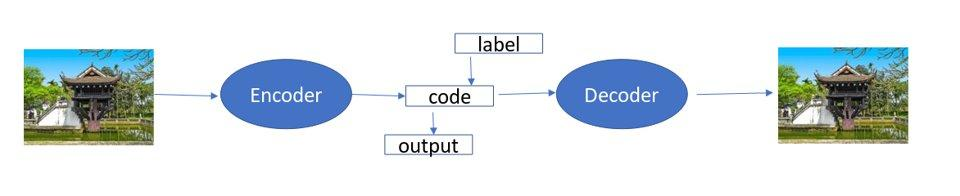




Chúng ta cùng cài đặt qua 3 lớp này:


Tham khảo tại: https://www.kaggle.com/ziliwang/baseline-pytorch-bilstm

In [ ]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F

embedding_dim = 300
embedding_path = '../save/embedding_matrix.npy'  # or False, not use pre-trained-matrix
use_pretrained_embedding = True

hidden_size = 60
gru_len = hidden_size

Routings = 4 #5
Num_capsule = 5
Dim_capsule = 5 #16
dropout_p = 0.25
rate_drop_dense = 0.28
LR = 0.001
T_epsilon = 1e-7
num_classes = 30


class Embed_Layer(nn.Module):
    def __init__(self, embedding_matrix=None, vocab_size=None, embedding_dim=300):
        super(Embed_Layer, self).__init__()
        self.encoder = nn.Embedding(vocab_size + 1, embedding_dim)
        if use_pretrained_embedding:
            self.encoder.weight.data.copy_(t.from_numpy(embedding_matrix)) 

    def forward(self, x, dropout_p=0.25):
        return nn.Dropout(p=dropout_p)(self.encoder(x))


class GRU_Layer(nn.Module):
    def __init__(self):
        super(GRU_Layer, self).__init__()
        self.gru = nn.GRU(input_size=300,
                          hidden_size=gru_len,
                          bidirectional=True)


    def init_weights(self):
        ih = (param.data for name, param in self.named_parameters() if 'weight_ih' in name)
        hh = (param.data for name, param in self.named_parameters() if 'weight_hh' in name)
        b = (param.data for name, param in self.named_parameters() if 'bias' in name)
        for k in ih:
            nn.init.xavier_uniform_(k)
        for k in hh:
            nn.init.orthogonal_(k)
        for k in b:
            nn.init.constant_(k, 0)

    def forward(self, x):
        return self.gru(x)


# core caps_layer with squash func
class Caps_Layer(nn.Module):
    def __init__(self, input_dim_capsule=gru_len * 2, num_capsule=Num_capsule, dim_capsule=Dim_capsule, \
                 routings=Routings, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Caps_Layer, self).__init__(**kwargs)

        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size  
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = self.squash
        else:
            self.activation = nn.ReLU(inplace=True)

        if self.share_weights:
            self.W = nn.Parameter(
                nn.init.xavier_normal_(t.empty(1, input_dim_capsule, self.num_capsule * self.dim_capsule)))
        else:
            self.W = nn.Parameter(
                t.randn(BATCH_SIZE, input_dim_capsule, self.num_capsule * self.dim_capsule))  # 64bit-batch_size

    def forward(self, x):

        if self.share_weights:
            u_hat_vecs = t.matmul(x, self.W)
        else:
            print('add later')

        batch_size = x.size(0)
        input_num_capsule = x.size(1)
        u_hat_vecs = u_hat_vecs.view((batch_size, input_num_capsule,
                                      self.num_capsule, self.dim_capsule))
        u_hat_vecs = u_hat_vecs.permute(0, 2, 1, 3)  # (batch_size,num_capsule,input_num_capsule,dim_capsule)
        b = t.zeros_like(u_hat_vecs[:, :, :, 0])  # (batch_size,num_capsule,input_num_capsule)

        for i in range(self.routings):
            b = b.permute(0, 2, 1)
            c = F.softmax(b, dim=2)
            c = c.permute(0, 2, 1)
            b = b.permute(0, 2, 1)
            outputs = self.activation(t.einsum('bij,bijk->bik', (c, u_hat_vecs)))  # batch matrix multiplication
            # outputs shape (batch_size, num_capsule, dim_capsule)
            if i < self.routings - 1:
                b = t.einsum('bik,bijk->bij', (outputs, u_hat_vecs))  # batch matrix multiplication
        return outputs  # (batch_size, num_capsule, dim_capsule)

    # text version of squash, slight different from original one
    def squash(self, x, axis=-1):
        s_squared_norm = (x ** 2).sum(axis, keepdim=True)
        scale = t.sqrt(s_squared_norm + T_epsilon)
        return x / scale
    
class Capsule_Main(nn.Module):
    def __init__(self, embedding_matrix=None, vocab_size=None):
        super(Capsule_Main, self).__init__()
        self.embed_layer = Embed_Layer(embedding_matrix, vocab_size)
        self.gru_layer = GRU_Layer()
        self.gru_layer.init_weights()
        self.caps_layer = Caps_Layer()
        self.dense_layer = Dense_Layer()

    def forward(self, content):
        content1 = self.embed_layer(content)
        content2, _ = self.gru_layer(
            content1)  #output(seq_len, batch_size, num_directions * hidden_size)
        content3 = self.caps_layer(content2)
        output = self.dense_layer(content3)
        return output
    


## 3.c CLR - Cyclic Learning Rate

**Learning rate** là một **tham số** để điều chỉnh mức độ **trọng số** của mạng **neural**. Khi sử dụng **gradient descent**, mục tiêu của chúng ta là tìm ra **cực tiểu** của **hàm mất mát** (*loss function*) trong mô hình. Tuy nhiên ta lại có một vấn đề như hình bên dưới: 

<img src="https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png" width=900>

Thật vậy, khi **learning rate thấp**, chúng ta sẽ mất **nhiều thời gian** hơn để tìm ra được cực tiểu của *loss function*. Khi **learning rate quá cao**, tình hình còn trở nên **tồi tệ hơn**. Vì vậy, ta sẽ dùng **Cyclic Learning Rate** để giải quyết vấn đề này.

Khi sử dụng CLR, chúng ta sẽ:
* Định nghĩa một **minimum learning rate.**
* Định nghĩa một **maximum learning rate.**
* Cho phép learning rate **dao động** theo chu kỳ giữa **2 khoảng giới hạn** trên. 

<img src="https://pyimagesearch.com/wp-content/uploads/2019/07/keras_clr_triangular.png" width=900>

Tham khảo tại: https://www.kaggle.com/dannykliu/lstm-with-attention-clr-in-pytorch
<!-- 
https://www.pyimagesearch.com/2019/07/29/cyclical-learning-rates-with-keras-and-deep-learning/

https://www.datacamp.com/community/tutorials/cyclical-learning-neural-nets -->

In [ ]:
class CyclicLR(object):
    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs


## 3.d Attention

<!-- https://machinelearningmastery.com/attention-long-short-term-memory-recurrent-neural-networks/ -->

Như đã đề cập ở trên, em cũng sẽ sử dụng **attention** vào trong mô hình. *Attention* hiện đang nhận được rất nhiều sự quan tâm từ cộng đồng *Machine Learning*, *Deep Learning* trong thời gian gần đây. Trong các bài toán làm việc với văn bản như dự án này, *attention* luôn được đánh giá cao khi nó khiến mô hình **tập trung** nhiều hơn vào các **từ khóa chính** hay các **câu** văn mang lại **nhiều thông tin** trong văn bản gốc. Dưới đây là một **ví dụ** làm việc với câu "Germany emerge victorious in 2-0 with against Argentina on Sartuday..

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/09/Pointer-generator-model-for-Text-Summarization.png">

Chúng ta cùng cài đặt attention và mô hình như dưới đây:

In [ ]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)
    
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        fc_layer = 16
        fc_layer1 = 16

        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)

        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)

        self.lstm_attention = Attention(hidden_size * 2, maxlen)
        self.gru_attention = Attention(hidden_size * 2, maxlen)
        self.bn = nn.BatchNorm1d(16, momentum=0.5)
        self.linear = nn.Linear(hidden_size*8+3, fc_layer1) #643:80 - 483:60 - 323:40
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(fc_layer**2,fc_layer)
        self.out = nn.Linear(fc_layer, 1)
        self.lincaps = nn.Linear(Num_capsule * Dim_capsule, 1)
        self.caps_layer = Caps_Layer()
    
    def forward(self, x):
        
#         Capsule(num_capsule=10, dim_capsule=10, routings=4, share_weights=True)(x)

        h_embedding = self.embedding(x[0])
        h_embedding = torch.squeeze(
            self.embedding_dropout(torch.unsqueeze(h_embedding, 0)))
        
        h_lstm, _ = self.lstm(h_embedding)
        h_gru, _ = self.gru(h_lstm)

        ##Capsule Layer        
        content3 = self.caps_layer(h_gru)
        content3 = self.dropout(content3)
        batch_size = content3.size(0)
        content3 = content3.view(batch_size, -1)
        content3 = self.relu(self.lincaps(content3))

        ##Attention Layer
        h_lstm_atten = self.lstm_attention(h_lstm)
        h_gru_atten = self.gru_attention(h_gru)
        
        # global average pooling
        avg_pool = torch.mean(h_gru, 1)
        # global max pooling
        max_pool, _ = torch.max(h_gru, 1)
        
        f = torch.tensor(x[1], dtype=torch.float).cuda()

                #[512,160]
        conc = torch.cat((h_lstm_atten, h_gru_atten,content3, avg_pool, max_pool,f), 1)
        conc = self.relu(self.linear(conc))
        conc = self.bn(conc)
        conc = self.dropout(conc)

        out = self.out(conc)
        
        return out

# 4. Huấn luyện mô hình
## 4.a Huấn luyện và dự đoán
Tham khảo tại: https://www.kaggle.com/hengzheng/pytorch-starter

Đầu tiên em **khởi tạo** các biến, mảng và **load** dữ liệu cần thiết cho việc *train* và *predict*.

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# matrix for the out-of-fold predictions
train_preds = np.zeros((len(x_train)))
# matrix for the predictions on the test set
test_preds = np.zeros((len(df_test)))

# always call this before training for deterministic results
seed_everything()

# x_test_cuda_f = torch.tensor(x_test_f, dtype=torch.long).cuda()
# test_f = torch.utils.data.TensorDataset(x_test_cuda_f)
# test_loader_f = torch.utils.data.DataLoader(test_f, batch_size=batch_size, shuffle=False)


x_test_cuda = torch.tensor(x_test, dtype=torch.long).cuda()
test = torch.utils.data.TensorDataset(x_test_cuda)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

avg_losses_f = []
avg_val_losses_f = []

In [ ]:
class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        data, target = self.dataset[index]

        return data, target, index
    def __len__(self):
        return len(self.dataset)

Vì dữ liệu của chúng ta khá lớn nên để tránh bị underfitting khi cho hết dữ liệu vào trong một lần train, em sẽ chia dữ liệu thành một số epoch. Và chắc số epoch cũng không đủ lớn để model bị overfitting. 

Em sẽ *train* tập dữ liệu với **5 Fold** (K-Fold Cross Validation), mỗi Fold lại chia thành **5 epoch** với **batch size** là **512** 

<img src="https://scontent-hkg4-1.xx.fbcdn.net/v/t1.6435-9/74804493_436417456985391_5231059713130496_n.png?_nc_cat=106&ccb=1-3&_nc_sid=730e14&_nc_ohc=qp61hNRFutoAX83LKd0&_nc_ht=scontent-hkg4-1.xx&oh=90fa1ebcb492914b444c03f099c3b5ab&oe=60E7C2CD" width=900>

In [ ]:
for i, (train_idx, valid_idx) in enumerate(splits):    
    # split data in train / validation according to the KFold indeces
    # also, convert them to a torch tensor and store them on the GPU (done with .cuda())
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    features = np.array(features)

    x_train_fold = torch.tensor(x_train[train_idx.astype(int)], dtype=torch.long).cuda()
    y_train_fold = torch.tensor(y_train[train_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()
    
    kfold_X_features = features[train_idx.astype(int)]
    kfold_X_valid_features = features[valid_idx.astype(int)]
    x_val_fold = torch.tensor(x_train[valid_idx.astype(int)], dtype=torch.long).cuda()
    y_val_fold = torch.tensor(y_train[valid_idx.astype(int), np.newaxis], dtype=torch.float32).cuda()
    
    model = NeuralNet()

    # make sure everything in the model is running on the GPU
    model.cuda()

    # define binary cross entropy loss
    # note that the model returns logit to take advantage of the log-sum-exp trick 
    # for numerical stability in the loss
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='sum')

    step_size = 300
    base_lr, max_lr = 0.001, 0.003   
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=max_lr)
    
    ################################################################################################
    scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr,
               step_size=step_size, mode='exp_range',
               gamma=0.99994)
    ###############################################################################################

    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    
    train = MyDataset(train)
    valid = MyDataset(valid)

    ##No need to shuffle the data again here. Shuffling happens when splitting for kfolds.
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    print(f'Fold {i + 1}')
    for epoch in range(n_epochs):
        # set train mode of the model. This enables operations which are only applied during training like dropout
        start_time = time.time()
        model.train()

        avg_loss = 0.  
        for i, (x_batch, y_batch, index) in enumerate(train_loader):
            # Forward pass: compute predicted y by passing x to the model.
            ################################################################################################            
            f = kfold_X_features[index]
            y_pred = model([x_batch,f])
            ################################################################################################

            ################################################################################################

            if scheduler:
                scheduler.batch_step()
            ################################################################################################


            # Compute and print loss.
            loss = loss_fn(y_pred, y_batch)

            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the Tensors it will update (which are the learnable weights
            # of the model)
            optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            
        # set evaluation mode of the model. This disabled operations which are only applied during training like dropout
        model.eval()
        
        # predict all the samples in y_val_fold batch per batch
        valid_preds_fold = np.zeros((x_val_fold.size(0)))
        test_preds_fold = np.zeros((len(df_test)))
        
        avg_val_loss = 0.
        for i, (x_batch, y_batch, index) in enumerate(valid_loader):
            f = kfold_X_valid_features[index]
            y_pred = model([x_batch,f]).detach()
            
            avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
            valid_preds_fold[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
        
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
            epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
    avg_losses_f.append(avg_loss)
    avg_val_losses_f.append(avg_val_loss) 
    # predict all samples in the test set batch per batch
    for i, (x_batch,) in enumerate(test_loader):
        f = test_features[i * batch_size:(i+1) * batch_size]
        y_pred = model([x_batch,f]).detach()

        test_preds_fold[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
        
    train_preds[valid_idx] = valid_preds_fold
    test_preds += test_preds_fold / len(splits)

print('All \t loss={:.4f} \t val_loss={:.4f} \t '.format(np.average(avg_losses_f),np.average(avg_val_losses_f)))

# x_train, x_test_f, y_train, y_test_f

<!-- https://www.phamduytung.com/blog/2018-10-02-understanding-epoch-batchsize-iterations/ -->
Có thể thấy rằng khi **bắt đầu** vào *Fold* mới, **loss** của các Epoch đầu khá **cao**, khoảng **80** nhưng sẽ **giảm dần** xuống khoảng **dưới 50** với mọi *Fold*. Vậy là mô hình đã hoạt động và có kết quả **tốt** khi được huấn luyện với tập *train*. Thời gian chạy cho một *epoch* cũng khá lâu với **90s**. 

Tuy nhiên để đánh giá **độ chính xác** của *model*, chúng ta sẽ **không dùng accuracy** như thường lệ. Vì như ở phần 2a (Khảo sát dữ liệu), ta đã nhận định rằng tập dữ liệu bị lệch **(imbalance)** khá nặng nên phải sử dụng **f1_score** để đánh giá độ chính xác của mô hình. **F1_score** là một thang điểm từ 0 đến 1 để đánh giá chất lượng mô hình. Chỉ số **F1_score** càng cao càng tốt, **lý tưởng** nhất là bằng **1** khi *Precision* = *Recall* = 1

Sau đây là một số công thức liên quan đến chúng:

<img src="https://static.packt-cdn.com/products/9781785282287/graphics/B04223_10_02.jpg">




## 4.b Find final Thresshold
Ta cùng **tìm** ***thresshold*** tốt nhất để có được **f1_score tốt nhất** khi *submit* lên *Kaggle*

In [ ]:
def bestThresshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in tqdm(np.arange(0.1, 0.501, 0.01)):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))
    return delta
delta = bestThresshold(y_train,train_preds)

Vậy *threshold* ta tìm được là **0.3** với f1_score là **0.6811**

In [ ]:
submission = df_test[['qid']].copy()
submission['prediction'] = (test_preds > delta).astype(int)
submission.to_csv('submission.csv', index=False)

In [ ]:
!head submission.csv

### Tài liệu tham khảo: 
* https://www.kaggle.com/gmhost/gru-capsule
* How to: Preprocessing when using embeddings
https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings
* Improve your Score with some Text Preprocessing
https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing
* Simple attention layer taken from https://github.com/mttk/rnn-classifier/blob/master/model.py
* https://www.kaggle.com/ziliwang/baseline-pytorch-bilstm
* https://www.kaggle.com/hengzheng/pytorch-starter
* https://www.kaggle.com/shujian/mix-of-nn-models-based-on-meta-embedding
* https://www.kaggle.com/sudalairajkumar/a-look-at-different-embeddings
* https://www.kaggle.com/shujian/single-rnn-with-4-folds-clr